In [1]:
import sys
import os
from tempfile import NamedTemporaryFile
from gc import collect
from time import sleep
sys.path.append('../util')
from meters import ThroughputMeter, clear_host_cache
from ncgen import make_nc
from grids import *
import netCDF4
import numpy as np

In [2]:
def write_netcdf_file(timescale, time_major=True, grid=canada_5k):
    print("Creating a time-{} NetCDF file with {}x{} grid and {} time steps".format('major' if time_major else 'minor', grid['lon']['count'], grid['lat']['count'],len(timescale)))
    with NamedTemporaryFile(suffix='.nc', delete=False, dir='/app/tmp') as f:
        nc = make_nc(f.name, grid=grid, timescale=timescale, timemajor=time_major)
        nc.close()
    print("File size: {:.2f}Mb".format(os.path.getsize(f.name)/1024/1024))
    return f

../tmp path in the Docker container points at rotating media storage.

In [3]:
def netcdf_read_test(f, time_major):
    # Open the file just created
    nc = netCDF4.Dataset(f.name, 'r')
    if time_major:
        with ThroughputMeter() as t:
            a = nc.variables['var_0'][0,:,:]

    else:
        with ThroughputMeter() as t:
            a = nc.variables['var_0'][:,:,0]
    res = (time_major, len(timescale), t.megabytes_per_second(a))
    # python-netCDF4 seems to leak file descriptors
    # We have to take a lot of steps to make sure that the files get closed and that
    # the space gets reclaimed by the OS
    nc.close
    del nc
    print("Removing {}".format(f.name))
    os.remove(f.name)
    f.close()
    collect()
    return res

### Test scenarios

In [4]:
time_major = [True, False]
grids = [world_250k, world_125k, canada_5k]
ts = [timescales['seasonal'], timescales['annual'], timescales['monthly']] # Daily takes hours and hours to run #, timescales['daily']]

In [5]:
results = []

for tm in time_major:
    for grid in grids:
        for timescale in ts:
            testfile = write_netcdf_file(timescale, time_major=tm, grid=grid)
            clear_host_cache()
            results.append(netcdf_read_test(testfile, tm))

Creating a time-major NetCDF file with 128x64 grid and 17 time steps
File size: 0.54Mb
host cache cleared
0.031 MB in 0.0077 seconds at 4.058 MB / sec
Removing /app/tmp/tmpjsm6ax8p.nc
Creating a time-major NetCDF file with 128x64 grid and 150 time steps
File size: 4.70Mb
host cache cleared
0.031 MB in 0.000878 seconds at 35.608 MB / sec
Removing /app/tmp/tmpdcvfxend.nc
Creating a time-major NetCDF file with 128x64 grid and 1800 time steps
File size: 56.26Mb
host cache cleared
0.031 MB in 0.0923 seconds at 0.339 MB / sec
Removing /app/tmp/tmpi826megp.nc
Creating a time-major NetCDF file with 256x128 grid and 17 time steps
File size: 2.13Mb
host cache cleared
0.125 MB in 0.00467 seconds at 26.740 MB / sec
Removing /app/tmp/tmp_uzzsbcm.nc
Creating a time-major NetCDF file with 256x128 grid and 150 time steps
File size: 18.76Mb
host cache cleared
0.125 MB in 0.000896 seconds at 139.438 MB / sec
Removing /app/tmp/tmpmf7bcje1.nc
Creating a time-major NetCDF file with 256x128 grid and 1800 ti

## Summarize Results

In [6]:
results

[(True, 17, 4.0583335913552343),
 (True, 150, 35.607715294756858),
 (True, 1800, 0.33873635461462126),
 (True, 17, 26.739837813025961),
 (True, 150, 139.43829787234043),
 (True, 1800, 70.317596566523605),
 (True, 17, 1733.6144817982893),
 (True, 150, 38.773814078892336),
 (True, 1800, 4.8505735610880132),
 (False, 17, 27.751852636036418),
 (False, 150, 15.544592030360532),
 (False, 1800, 2.5942522365608425),
 (False, 17, 60.611329479768784),
 (False, 150, 22.717102127475194),
 (False, 1800, 0.024986046000921115),
 (False, 17, 188.93229561861816),
 (False, 150, 0.32834688798594031),
 (False, 1800, 0.035178585407501448)]

Reshape to dimensions timescale, grid, time_major

In [7]:
a = np.array([r[2] for r in results]).reshape(len(time_major),len(grids),len(ts))
a

array([[[  4.05833359e+00,   3.56077153e+01,   3.38736355e-01],
        [  2.67398378e+01,   1.39438298e+02,   7.03175966e+01],
        [  1.73361448e+03,   3.87738141e+01,   4.85057356e+00]],

       [[  2.77518526e+01,   1.55445920e+01,   2.59425224e+00],
        [  6.06113295e+01,   2.27171021e+01,   2.49860460e-02],
        [  1.88932296e+02,   3.28346888e-01,   3.51785854e-02]]])

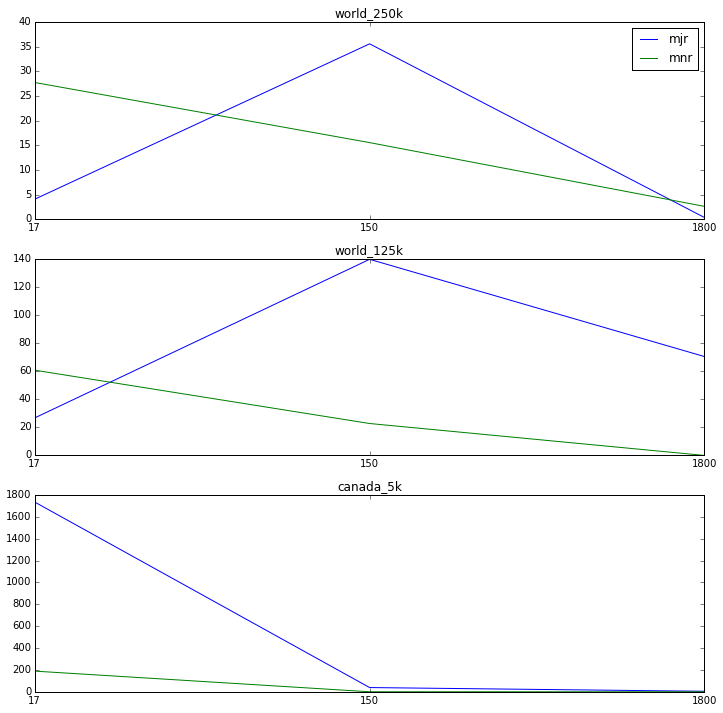

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

f, (ax1, ax2, ax3) = plt.subplots(3, 1)
f.set_size_inches(12, 12)

ax1.plot(a[0,0,:], label="mjr")
ax1.plot(a[1,0,:], label="mnr")
ax1.legend()
ax1.set_title("world_250k")
ax1.set_xticks(range(len(ts)))
ax1.set_xticklabels([len(x) for x in ts])

ax2.plot(a[0,1,:], label="mjr")
ax2.plot(a[1,1,:], label="mnr")
ax2.set_title("world_125k")
ax2.set_xticks(range(len(ts)))
ax2.set_xticklabels([len(x) for x in ts])

ax3.plot(a[0,2,:], label="mjr")
ax3.plot(a[1,2,:], label="mnr")
ax3.set_title("canada_5k")
ax3.set_xticks(range(len(ts)))
ax3.set_xticklabels([len(x) for x in ts])